# PUB - performance evaluation

In [24]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 150

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data

In [29]:
# run_dir = Path("/datadrive/data/runs/azure_nh_runoff_30EPOCH_0306_173310")
# run_dir = Path("/datadrive/data/runs/azure_nh_runoff_30EPOCH_0306_200242")
data_dir = Path("/datadrive/data")
run_dir = Path("/home/tommy/neuralhydrology/runs/lstm_PUB_azure_3006_101251")

# load config
cfg = Config(run_dir / "config.yml")
cfg.run_dir = run_dir

In [4]:
res_fp = get_test_filepath(run_dir, epoch=30)
preds = get_all_station_ds(res_fp)

100%|██████████| 134/134 [00:00<00:00, 1989.60it/s]


In [37]:
from scripts.geospatial import load_latlon_points, initialise_gb_spatial_plot
points = load_latlon_points(data_dir)
static = xr.open_dataset(data_dir / "camels_static.nc")
# ax = initialise_gb_spatial_plot()
# points.plot(ax=ax, color="grey", markersize=20)

In [43]:
# ds[["precipitation", "temperature", "discharge_spec"]]
static

<xarray.Dataset>
Dimensions:                       (station_id: 671)
Coordinates:
  * station_id                    (station_id) int64 1001 2001 ... 106001 107001
Data variables: (12/145)
    sand_perc                     (station_id) float64 39.25 41.66 ... 65.32
    sand_perc_missing             (station_id) float64 3.16 2.78 ... 0.0 0.0
    silt_perc                     (station_id) float64 31.97 25.28 ... 17.63
    silt_perc_missing             (station_id) float64 3.16 2.78 ... 0.0 0.0
    clay_perc                     (station_id) float64 28.79 33.06 ... 17.06
    clay_perc_missing             (station_id) float64 3.16 2.78 ... 0.0 0.0
    ...                            ...
    frac_high_perc                (station_id) float64 0.0 0.0 0.0 ... 0.0 0.0
    frac_mod_perc                 (station_id) float64 2.24 1.01 ... 0.0 4.92
    frac_low_perc                 (station_id) float64 0.0 3.26 ... 4.71 0.0
    no_gw_perc                    (station_id) float64 87.55 85.86 ... 85.31
    low_nsig_perc                 (station_id) float64 0.0 0.0 0.07 ... 0.0 0.0
    nsig_low_perc                 (station_id) float64 0.0 0.0 0.0 ... 0.0 0.0

# Load model

In [5]:
# load trained model
model = get_model(cfg).to(cfg.device)
_load_weights(model, cfg)
model

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


Using the model weights from /home/tommy/neuralhydrology/runs/lstm_PUB_azure_3006_101251/model_epoch030.pt


CudaLSTM(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (lstm): LSTM(25, 64)
  (dropout): Dropout(p=0.4, inplace=False)
  (head): Regression(
    (net): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

# Get training/test dataset

In [6]:
ds = xr.open_dataset("/home/tommy/spatio_temporal/data/ALL_dynamic_ds.nc")

def read_basin_list(txt_path: Path) -> pd.DataFrame:
    return pd.read_csv(txt_path, header=None).rename({0: "station_id"}, axis=1)


train_sids = read_basin_list(cfg.train_basin_file)
test_sids = read_basin_list(cfg.test_basin_file)
train_ds = ds.sel(time=slice(cfg.train_start_date, cfg.train_end_date), station_id=np.isin(ds.station_id, train_sids.station_id))
test_ds = ds.sel(time=slice(cfg.test_start_date, cfg.test_end_date), station_id=np.isin(ds.station_id, test_sids.station_id))

# Check the Performance of model

In [7]:
if not (run_dir / "errors.nc").exists():
    errors = calculate_all_error_metrics(preds, basin_coord="station_id")
    errors["station_id"] = errors["station_id"].astype(int)
    errors.to_netcdf(run_dir / "errors.nc")

else:
    print("Already run errors!")
    errors = xr.open_dataset((run_dir / "errors.nc"))

Calculating Errors:  27%|██▋       | 36/134 [00:06<00:16,  6.03it/s, 30012]/home/tommy/neuralhydrology/neuralhydrology/evaluation/metrics.py:523: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs)
Calculating Errors:  28%|██▊       | 37/134 [00:06<00:17,  5.44it/s, 30014]/home/tommy/neuralhydrology/neuralhydrology/evaluation/metrics.py:523: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs)
Calculating Errors:  41%|████      | 55/134 [00:09<00:14,  5.32it/s, 38017]/home/tommy/neuralhydrology/neuralhydrology/evaluation/metrics.py:523: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs)
Calculating Errors:  47%|████▋     | 63/134 [00:10<00:10,  6.84it/s, 39114]/home/tommy/neuralhydrology/neuralhydrology/evaluation/metrics.py:523: RuntimeWarning: invalid value encountered in log
  obs = np.log(obs)
Calculating Errors: 100%|██████████| 134/134 [00:22<00:00,  5.90it/s, 96001]


## Get comparison model

In [8]:
# comparison
orig_run_dir = Path("/datadrive/data/runs/azure_nh_runoff_30EPOCH_PIXEL_ALL_STATIC_0406_093025")
orig_res_fp = get_test_filepath(orig_run_dir, epoch=30)
orig_preds = get_all_station_ds(orig_res_fp)
orig_preds["station_id"] = orig_preds["station_id"].astype(int)

if "orig_errors" not in globals():
    orig_errors = calculate_all_error_metrics(orig_preds, basin_coord="station_id")
else:
    print("Already run errors!")

Calculating Errors: 100%|██████████| 669/669 [01:57<00:00,  5.70it/s, 97002]


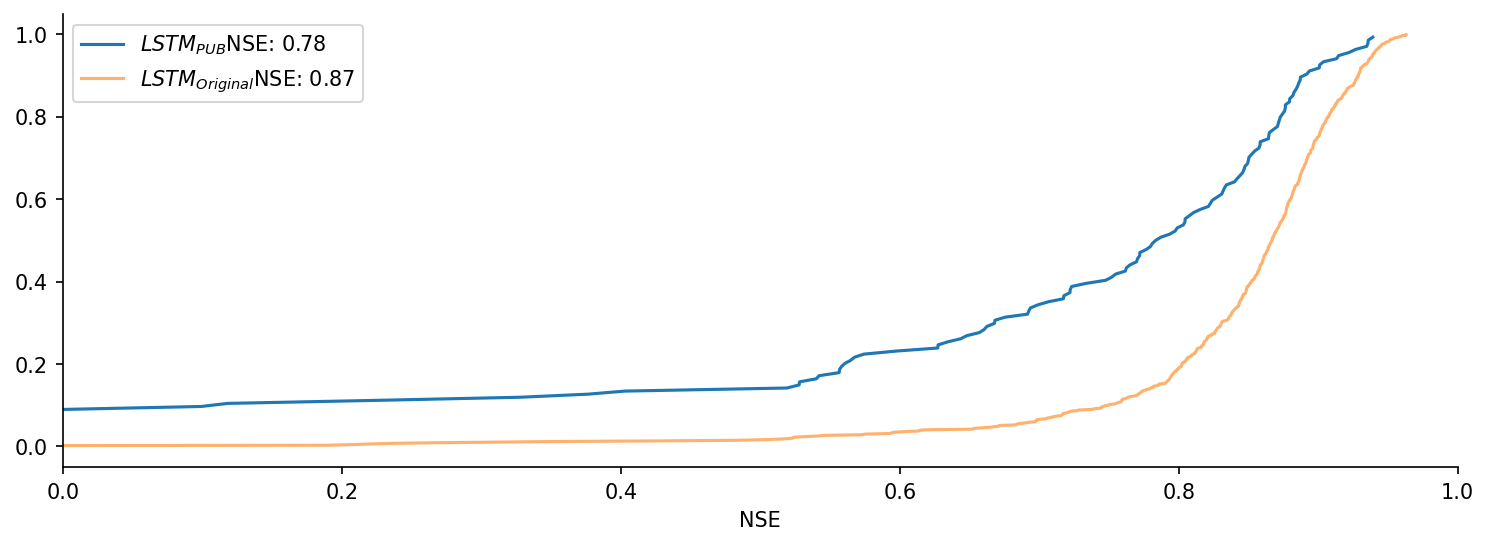

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from scripts.cell_state.analysis import empirical_cdf

f, ax = plt.subplots(figsize=(12, 4))
med_nse = np.median(orig_errors["NSE"].values)
med_nse_pub = np.median(errors["NSE"].values)
empirical_cdf(errors["NSE"].values[np.isfinite(errors["NSE"])], ax=ax, kwargs={"color": "C0", "label": "$LSTM_{PUB}$" + f"NSE: {med_nse_pub:.2f}"})
empirical_cdf(orig_errors["NSE"].values[np.isfinite(orig_errors["NSE"])], ax=ax, kwargs={"color": "C1", "alpha": 0.6, "label": "$LSTM_{Original}$" + f"NSE: {med_nse:.2f}"})

plt.legend()
ax.set_xlabel("NSE")
ax.set_xlim(0, 1)
sns.despine()

In [10]:
# (errors["NSE"] < 0).sum()

In [11]:
def print_summaries(errors: xr.Dataset):
    print(f"Median NSE: \t{float((errors['NSE']).median().values):.2f}")
    print(f"Mean NSE: \t{float((errors['NSE']).mean().values):.2f}")
    print(f"Min NSE: \t{float((errors['NSE']).min().values):.2f}")
    print(f"Max NSE: \t{float((errors['NSE']).max().values):.2f}")
    print(f"P(Errors < 0): \t{(errors['NSE'] < 0).mean().values:.2f}")
    print("\n")

print_summaries(errors)
print_summaries(errors.where(errors["NSE"] > 0))

Median NSE: 	0.78
Mean NSE: 	0.57
Min NSE: 	-3.36
Max NSE: 	0.94
P(Errors < 0): 	0.10


Median NSE: 	0.80
Mean NSE: 	0.75
Min NSE: 	0.10
Max NSE: 	0.94
P(Errors < 0): 	0.00




# Scatter Plot

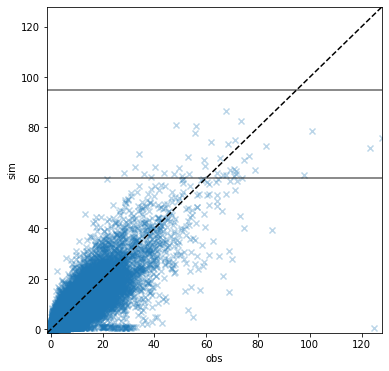

In [12]:
from scripts.plots import scatter_plot

x, y = preds["discharge_spec_obs"].values.flatten(), preds["discharge_spec_sim"].values.flatten()
scatter_plot(obs=x, sim=y)
ax = plt.gca()
ax.axhline(60, ls="-", alpha=0.6, color="k")
ax.axhline(95, ls="-", alpha=0.6, color="k");

In [19]:
sids

<xarray.DataArray 'station_id' (station_id: 7)>
array(['15024', '25003', '55008', '58001', '58002', '72005', '76014'],
      dtype='<U6')
Coordinates:
  * station_id  (station_id) <U6 '15024' '25003' '55008' ... '72005' '76014'

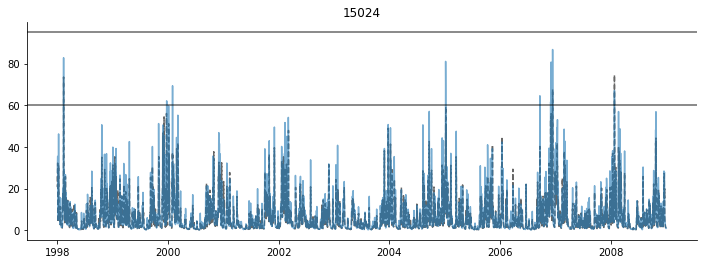

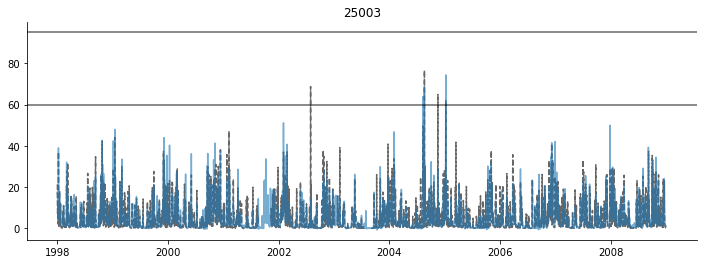

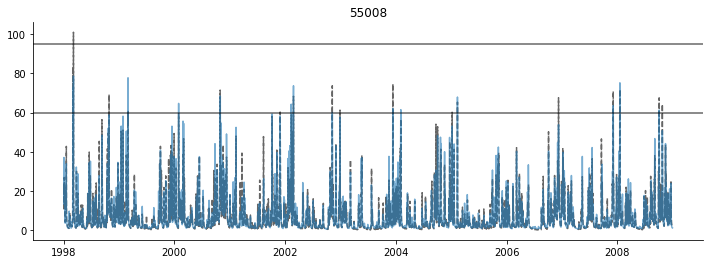

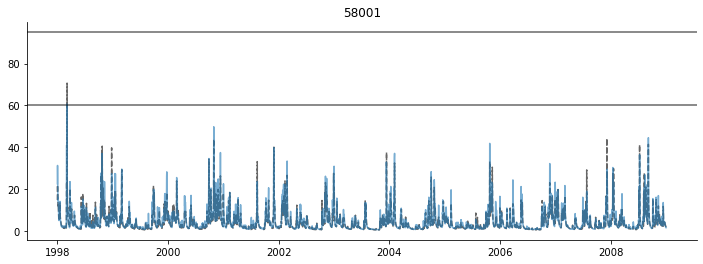

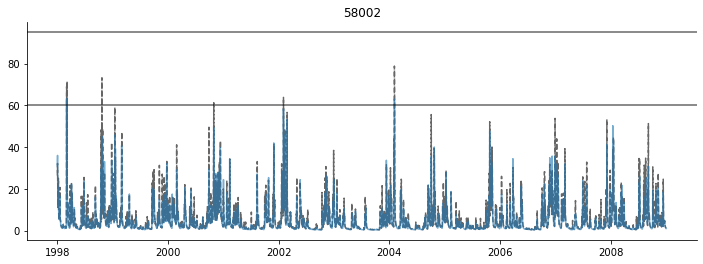

In [22]:
sids = preds.where((preds["discharge_spec_sim"] > 60) & (preds["discharge_spec_sim"] < 95), drop=True).station_id

for sid in sids[:5]:
    f, ax = plt.subplots(figsize=(12, 4))
    d = preds.sel(station_id=sid)
    ax.plot(d["date"], d["discharge_spec_obs"], ls="--", color="k", alpha=0.6)
    ax.plot(d["date"], d["discharge_spec_sim"], color="C0", alpha=0.6)
    ax.axhline(60, ls="-", alpha=0.6, color="k")
    ax.axhline(95, ls="-", alpha=0.6, color="k");
    ax.set_title(str(sid.values))
    sns.despine()

# Visualise Hydrographs

In [20]:
preds["station_id"] = preds["station_id"].astype(int)
errors["station_id"] = errors["station_id"].astype(int)
orig_errors["station_id"] = orig_errors["station_id"].astype(int)

All NSE below 0.10


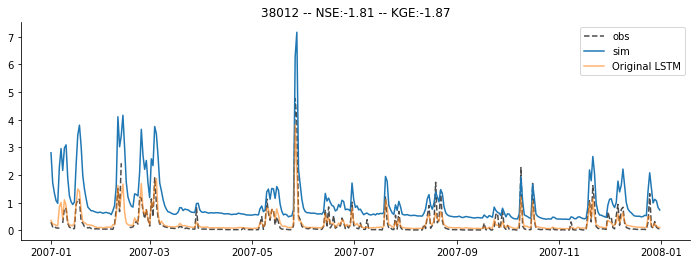

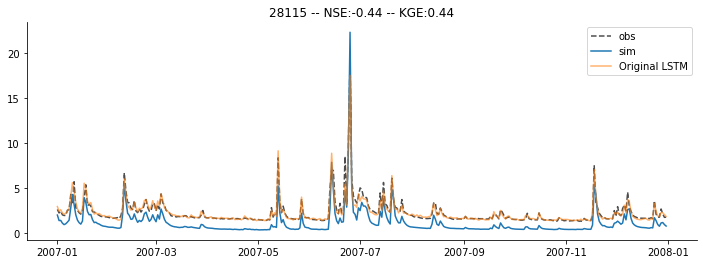

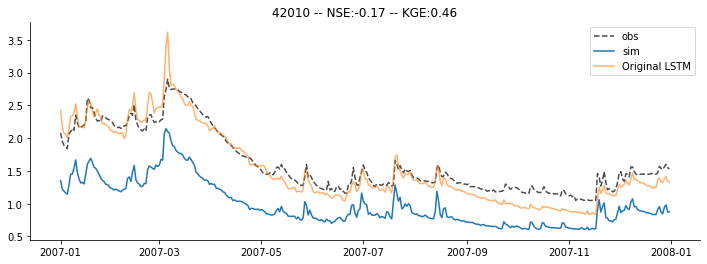

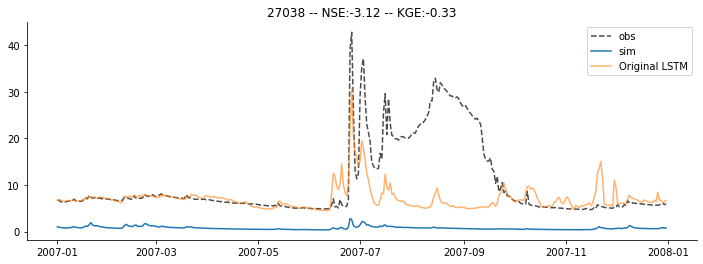

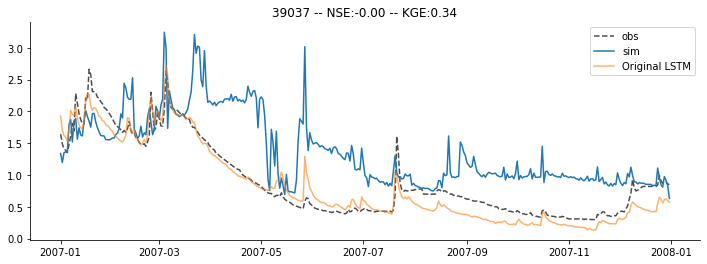

In [15]:
bottom_10_percent_sids = errors.where(
    errors["NSE"] < errors["NSE"].quantile(q=0.1), 
    drop=True
).station_id
below_0_sids = errors.where(
    errors["NSE"] < 0, 
    drop=True
).station_id
print(f"All NSE below {float(errors['NSE'].quantile(q=0.1)):.2f}")

N = 5
pixels = np.random.choice(below_0_sids, N, replace=False)
for pixel in pixels:
    f, ax = plt.subplots(figsize=(12, 4))
    #  preds.station_id.values   bottom_10_percent_sids
    p = preds.sel(date="2007", station_id=pixel)
    op = orig_preds.sel(date="2007", station_id=pixel)
    ax.plot(p.date, p["discharge_spec_obs"], label="obs", color="k", ls="--", alpha=0.7)
    ax.plot(p.date, p["discharge_spec_sim"], label="sim")
    ax.plot(p.date, op["discharge_spec_sim"], label="Original LSTM", alpha=0.6)
    
    ax.set_title(f"{pixel} -- NSE:{errors.sel(station_id=pixel).NSE.values:.2f} -- KGE:{errors.sel(station_id=pixel).KGE.values:.2f}")
    ax.legend()
    sns.despine()

# Visualise Spatially

In [16]:
import geopandas as gpd
from scripts.geospatial import initialise_gb_spatial_plot, load_latlon_points
from mpl_toolkits.axes_grid1 import make_axes_locatable

st_data_dir = Path("/home/tommy/spatio_temporal/data")
points = load_latlon_points(st_data_dir)
errors["station_id"] = errors["station_id"].astype(int)
static = xr.open_dataset(st_data_dir / "camels_static.nc")

In [17]:
np.isin(errors["NSE"].to_dataframe().index, points.index)
gdf = gpd.GeoDataFrame(errors.to_dataframe().join(points))
gdf.shape

(134, 12)

In [22]:
orig_gdf = orig_errors.sel(station_id=gdf.index).to_dataframe()
orig_gdf.index = orig_gdf.index.astype("int")
orig_gdf = gpd.GeoDataFrame(orig_gdf.join(points))
# orig_gdf.head()

Text(0.5, 1.0, 'Original')

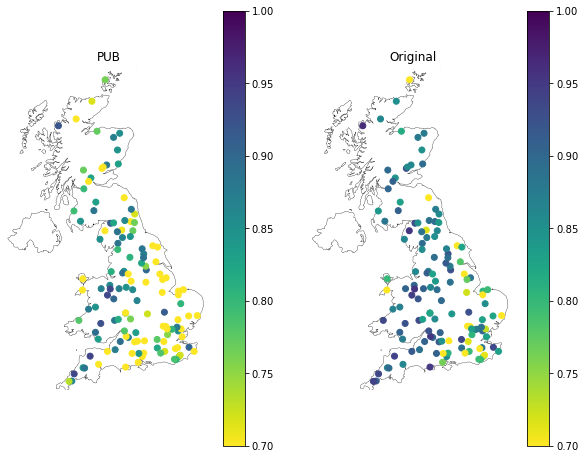

In [23]:
f, axs = plt.subplots(1, 2, figsize=(5*2, 8))
ax = axs[0]
initialise_gb_spatial_plot(ax=ax)
gdf.plot("NSE", ax=ax, vmin=0.7, vmax=1, cmap="viridis_r", legend=True)
ax.set_title("PUB")

ax = axs[1]
initialise_gb_spatial_plot(ax=ax)
orig_gdf.plot("NSE", ax=ax, vmin=0.7, vmax=1, cmap="viridis_r", legend=True)
ax.set_title("Original")

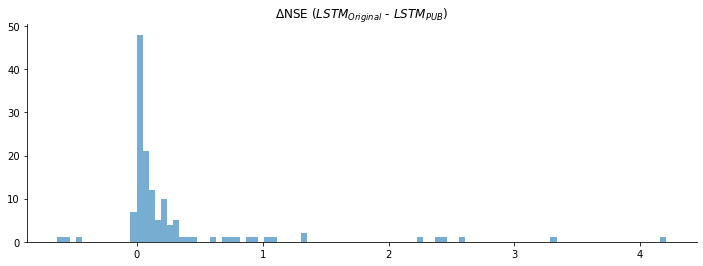

In [24]:
f, ax = plt.subplots(figsize=(12, 4))
ax.hist(orig_gdf["NSE"] - gdf["NSE"], bins=100, alpha=0.6);
ax.set_title("$\Delta$NSE ($LSTM_{Original}$ - $LSTM_{PUB}$)")
sns.despine() 

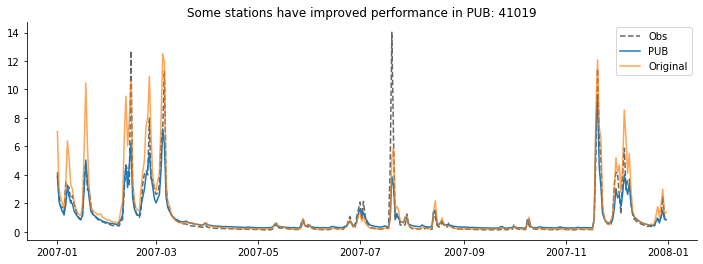

In [25]:
delta_nse = (orig_gdf["NSE"] - gdf["NSE"])

# 107001   41019   42026
pixel = np.random.choice(delta_nse.loc[delta_nse < 0].index)
pixel = 41019

op = orig_preds.sel(station_id=pixel, date="2007")
p = preds.sel(station_id=pixel, date="2007")

f, ax = plt.subplots(figsize=(12, 4))
ax.plot(p.date, p["discharge_spec_obs"], color="k", alpha=0.6, ls="--", label="Obs")
ax.plot(p.date, p["discharge_spec_sim"], label="PUB")
ax.plot(p.date, op["discharge_spec_sim"], label="Original", alpha=0.7)
ax.legend()
ax.set_title(f"Some stations have improved performance in PUB: {int(p.station_id)}")
sns.despine()

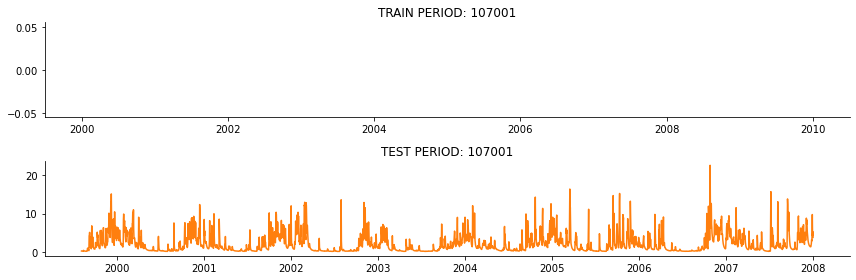

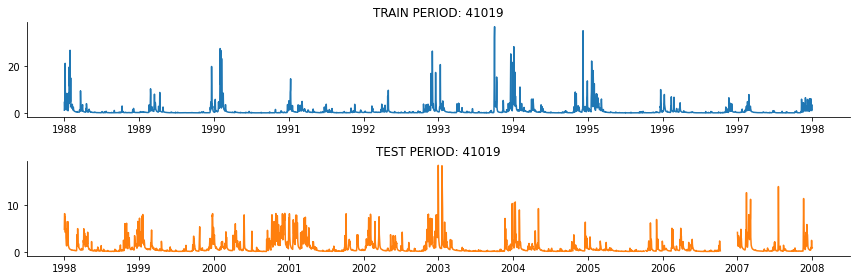

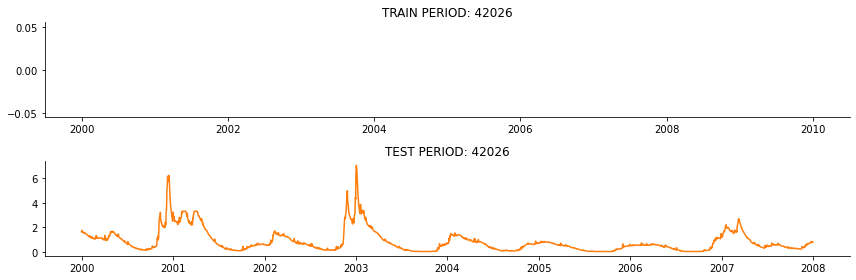

In [26]:
train_times = slice(cfg.train_start_date, cfg.train_end_date)
test_times = slice(cfg.test_start_date, "2008-01-01")

for pixel in [107001, 41019, 42026]:
    f, axs = plt.subplots(2, 1, figsize=(12, 4))
    ax = axs[0]
    d = ds.sel(time=train_times, station_id=pixel)
    ax.plot(d["time"], d["discharge_spec"], color="C0")
    ax.set_title(f"TRAIN PERIOD: {pixel}")
    ax = axs[1]
    d = ds.sel(time=test_times, station_id=pixel)
    ax.plot(d["time"], d["discharge_spec"], color="C1")
    ax.set_title(f"TEST PERIOD: {pixel}")
    plt.tight_layout()
    sns.despine()

# What about the probes?

In [27]:
assert False

AssertionError: 